In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import math

## Finite case
$x\in[M]$

In [2]:
M = 1000

### True function

In [3]:
_d = 10
param = np.random.uniform(size=_d) - 1/2
fmap = np.array([[(x/M)**y for y in range(_d)] for x in range(M)])
#fmap = np.random.uniform(size = (M, _d))
_f = np.matmul(fmap, param)
f = lambda x: _f[x]

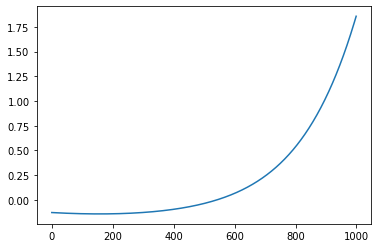

In [4]:
plt.plot(range(M), _f)

In [5]:
ylim = [min(_f)-0.1, max(_f)+0.1]

### Approximation with d random features (no noise)

In [6]:
def rfmap(d):
    return np.random.normal(size=(M,d))

In [7]:
def ols(X, y, reg=0):
    A = np.matmul(X.T,X) + reg * np.eye(d)
    b = np.matmul(X.T, y)
    theta = np.linalg.solve(A,b)
    return np.matmul(X, theta), theta

In [8]:
RF = rfmap(M)
err = np.zeros(M)
perr = np.zeros(M)
fhats = np.zeros((M,M))
for d in range(1, M+1):
    X = RF[:, :d] 
    y = _f
    fhat, theta = ols(X, y)
    fhats[d-1] = fhat
    err[d-1] = np.linalg.norm(fhat - _f, ord=1) / M
    

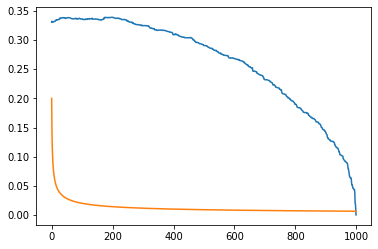

In [9]:
plt.plot(range(M), err)
plt.plot(range(M), 0.2/np.sqrt(range(1,M+1)))

In [10]:
xx = range(M)

def update(d = 1):
    plt.plot(xx, _f, xx, fhats[d-1])
    axes = plt.gca()
    axes.set_ylim(ylim)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=M, step=1, value=1))

interactive(children=(IntSlider(value=1, description='d', max=1000, min=1), Output()), _dom_classes=('widget-i…

### With noise

In [11]:
N = 900
noise = 0.001
reg = 1
S = np.random.choice(M, size=N, replace=True)
y = _f[S] + noise * np.random.normal(size=N)

In [12]:
RF = rfmap(M)
err = np.zeros(M)
fhats = np.zeros((M,M))
for d in range(1, M+1):
    X = RF[S, :d] 
    fhat, theta = ols(X, y, reg)
    err[d-1] = np.linalg.norm(np.matmul(RF[:, :d], theta) - _f, ord=1) / N
    fhats[d-1] = np.matmul(RF[:, :d], theta)

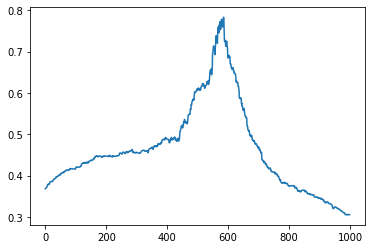

In [13]:
plt.plot(range(M), err)

In [14]:
xx = range(M)

def update(d = 1):
    plt.scatter(S,y)
    plt.plot(xx, fhats[d-1])
    axes = plt.gca()
    axes.set_ylim(ylim)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=M, step=1, value=M))

interactive(children=(IntSlider(value=1000, description='d', max=1000, min=1), Output()), _dom_classes=('widge…

## Linear case

$x\in\mathbb{R}^m$

In [15]:
def make_fun(m):
    param = 2 * np.random.uniform(size=m) - 1
    return lambda x : np.matmul(x, param)

In [16]:
#This represents functions of the form <x,c> + d
def make_rfm(d, m):
    A = np.random.normal(size=(d, m))
    b = np.random.normal(size=d)
    return lambda X: np.matmul(A, X.T).T + b

In [17]:
def ls(A, b, reg=0):
    return np.linalg.solve(np.matmul(A.T, A) + reg * np.eye(A.shape[-1]), np.matmul(A.T, b))

In [18]:
def rf_approx(X, y, d, reg=0):
    rfm = make_rfm(d, X.shape[-1])
    Phi = rfm(X) #Nxd
    theta = ls(Phi, y, reg)
    yhat = np.matmul(Phi, theta)
    return yhat, rfm, theta

In [19]:
def gen_rank(n, m, r):
    A = 2 * np.random.uniform(size=(n, r)) - 1
    B = 2 * np.random.uniform(size=(r, r)) - 1
    C = 2 * np.random.uniform(size=(r, m)) - 1
    M = np.matmul(np.matmul(A, B), C)
    assert np.linalg.matrix_rank(M) == r
    return M

### Scalar example

(-1.0, 1.0)

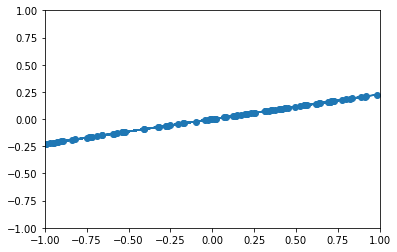

In [20]:
m = 1
N = 100
noise = 0
d = 2

f = make_fun(m)
X = 2 * np.random.uniform(size=(N, m)) - 1
y = f(X) + noise * np.random.normal(size=N)
yhat, _, _ = rf_approx(X, y, d)
xx = np.linspace(-1,1,100)
plt.scatter(X, y)
plt.plot(X, yhat)
ax = plt.gca()
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])

### Full-rank case

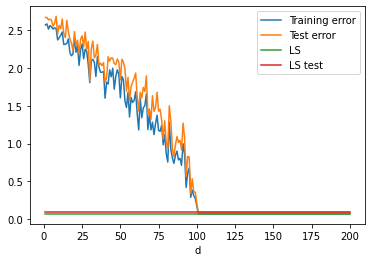

In [21]:
m = 100
N = 500
noise = 0.1
reg = 0
norm_ord = 1
max_d = 2 * m

f = make_fun(m)
X = 2 * np.random.uniform(size=(N, m)) - 1
y = f(X) + noise * np.random.normal(size=N)
ls_param = ls(X, y, reg)
yls = np.matmul(X, ls_param)
lserr = np.linalg.norm(yls - y, ord=norm_ord)**norm_ord / N
lsrank = np.linalg.matrix_rank(X)

X_test = 2 * np.random.uniform(size=(N, m)) - 1
y_test = f(X_test) + noise * np.random.normal(size=N)
yls_test = np.matmul(X_test, ls_param)
test_lserr = np.linalg.norm(yls_test - y_test, ord=norm_ord)**norm_ord / N

err = []
test_err = []
ranks = []
for d in range(1, max_d+1):
    yhat, rfm, theta = rf_approx(X, y, d, reg)
    err.append(np.linalg.norm(y - yhat, ord=norm_ord)**norm_ord / N)
    ranks.append(np.linalg.matrix_rank(rfm(X)))
    
    #Test
    yhat_test = np.matmul(rfm(X_test), theta)
    test_err.append(np.linalg.norm(y_test - yhat_test, ord=norm_ord)**norm_ord / N)

xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))

(0.0, 0.3845087868599882)

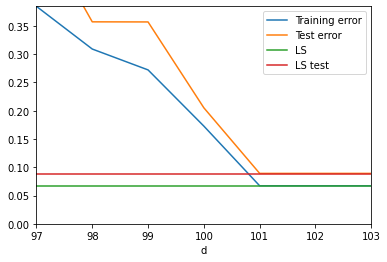

In [22]:
xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))
plt.gca().set_xlim((m-3, m+3))
plt.gca().set_ylim((0,err[m-4]))

100 101


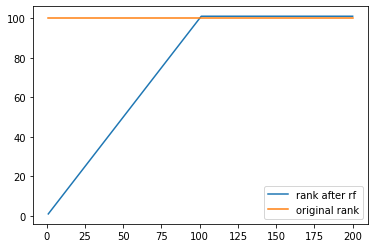

In [23]:
print(lsrank, np.max(ranks))
plt.plot(xx, ranks)
plt.plot((xx[0], xx[-1]),(lsrank, lsrank))
plt.legend(('rank after rf', 'original rank'))

In [24]:
for i in range(max_d): print(i+1, err[i], test_err[i], '\n')

1 2.5713694339015385 2.6716662398233337 

2 2.585934231975892 2.6709995306927117 

3 2.517146234953698 2.6385910924143574 

4 2.564916634997139 2.649160287148482 

5 2.545162365324113 2.6328810280859307 

6 2.5169807584378834 2.5550037762658513 

7 2.534707369715893 2.5949501261891896 

8 2.5219295963776527 2.6875425461058704 

9 2.37333614601658 2.453415693404485 

10 2.4044094246679864 2.566022562910037 

11 2.433428728077675 2.5218445512963834 

12 2.4794555644059644 2.650764162705584 

13 2.3131599949460635 2.455860439759753 

14 2.31683023379455 2.406157213415048 

15 2.327164471222378 2.634567524906655 

16 2.3876341718542506 2.4843077262271662 

17 2.206793603115665 2.3883296590355605 

18 2.1633082339240604 2.329769682803829 

19 2.1859482651609166 2.235529587681784 

20 2.4040062324872387 2.484424952402687 

21 2.2090606100229033 2.2947839416482316 

22 2.3019056154429034 2.3694589272632114 

23 2.0359120177587555 2.188394374187855 

24 2.2457399381577385 2.383476303328076 

2

### The rank-deficient case

98

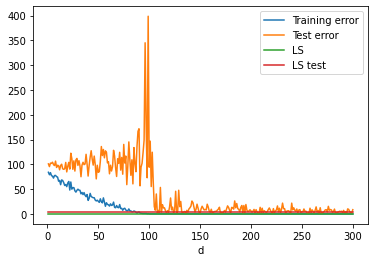

In [25]:
m = 100
N = 1000
noise = 0.1
reg = 0.1
norm_ord = 1
max_d = 3*m
rank = m - 1

f = make_fun(m)

#Contexts do not span R^d
X = gen_rank(N, m, rank)
lsrank = np.linalg.matrix_rank(X)

y = f(X) + noise * np.random.normal(size=N)
ls_param = ls(X, y, reg)
yls = np.matmul(X, ls_param)
lserr = np.linalg.norm(yls - y, ord=norm_ord)**norm_ord / N

X_test = gen_rank(N, m, rank)
y_test = f(X_test) + noise * np.random.normal(size=N)
yls_test = np.matmul(X_test, ls_param)
test_lserr = np.linalg.norm(yls_test - y_test, ord=norm_ord)**norm_ord / N

err = []
test_err = []
ranks = []
for d in range(1, max_d+1):
    yhat, rfm, theta = rf_approx(X, y, d, reg)
    err.append(np.linalg.norm(y - yhat, ord=norm_ord)**norm_ord / N)
    #print(rfm(X).shape)
    ranks.append(np.linalg.matrix_rank(rfm(X)))
    
    #Test
    yhat_test = np.matmul(rfm(X_test), theta)
    test_err.append(np.linalg.norm(y_test - yhat_test, ord=norm_ord)**norm_ord / N)

xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))
np.argmax(test_err)

99 100


Text(0.5, 0, 'd')

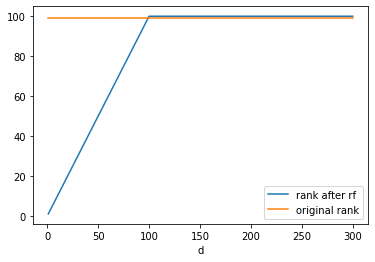

In [26]:
print(lsrank, np.max(ranks))
plt.plot(xx, ranks)
plt.plot((xx[0], xx[-1]),(lsrank, lsrank))
plt.legend(('rank after rf', 'original rank'))
plt.xlabel('d')

## Playing with perturbed matrices

1000
2
RFN:
1/1000
52/1000
1000/1000


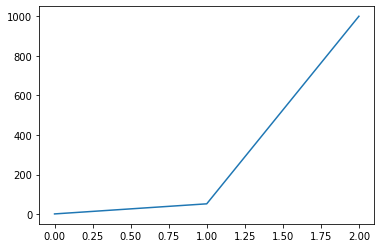

In [27]:
n = 2000
m = 1000
r = 1
A = gen_rank(n,m,r)
std = 1

B = A + np.random.normal(size=(n, m), scale=std)
print(np.linalg.matrix_rank(B))

C = A + np.random.normal(size=m, scale=std)
print(np.linalg.matrix_rank(C))


print('RFN:')
D = A
rank = np.linalg.matrix_rank(D)
ranks = [rank]
print('%d/%d' % (rank, min(m, n)))
max_layers = 100
activation = np.cos
#activation = lambda X: np.maximum(X, 0)
#activation = lambda X: X**2 / np.linalg.norm(X**2, 2)
#activation = lambda X: 0.01 * X**2
while(np.linalg.matrix_rank(D) < min(n, m) and len(ranks) < max_layers):
    W = np.random.normal(size=(n,n), scale=std)
    b = np.random.normal(size=m, scale=std)
    D = np.matmul(W, D) + b
    D = activation(D)
    rank = np.linalg.matrix_rank(D)
    ranks.append(rank)
    print('%d/%d' % (rank, min(m, n)))
plt.plot(range(len(ranks)), ranks)

## Fourier random features

### Gaussian kernel

In [28]:
#This represents functions in the RKHS of the Gaussian kernel k(x,x') = exp(-gamma||x-x'||^2) 
def make_fourier_rfm(d, m):
    W = np.random.normal(size=(m, d))
    b = np.random.uniform(low=0, high=2*math.pi, size=d)
    return lambda X: np.cos(np.matmul(X, W) + b)

In [29]:
def ls(A, b, reg=0):
    return np.linalg.solve(np.matmul(A.T, A) + reg * np.eye(A.shape[-1]), np.matmul(A.T, b))

def rf_fit(X, y, rfm, reg=0):
    Phi = rfm(X) #Nxd
    theta = ls(Phi, y, reg)
    yhat = np.matmul(Phi, theta)
    return yhat, theta, lambda Z: np.matmul(rfm(np.expand_dims(Z, 1)), theta)

The Gaussian kernel is universal, which basically means we can represent all continuous functions (on compact sets)

Let's try with polynomials (of scalar input)

In [30]:
from numpy.polynomial.polynomial import Polynomial as Poly

domain = [-1, 1]

def make_poly(order=5):
    coeff = 2 * np.random.uniform(size=order+1) - 1
    poly = Poly(coeff, domain)
    return lambda x: poly(x).squeeze()

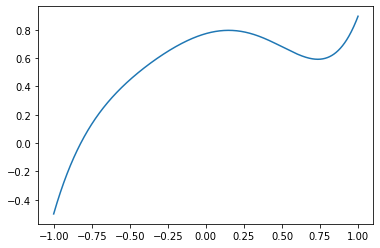

In [31]:
f = make_poly()
xx = np.linspace(domain[0], domain[1], num=1000)
plt.plot(xx, f(xx))

In [43]:
N = 100
noise = 0.1

X = 2 * np.random.uniform(size=(N, 1)) - 1
y = f(X) + noise * np.random.normal(size=N)

In [49]:
dmax = 20
reg = 0.1
results = []
ranks = []
for d in range(1, dmax+1):
    rfm = make_fourier_rfm(d, 1)
    results.append(rf_fit(X, y, rfm, reg))
    ranks.append(np.linalg.matrix_rank(rfm(X)))

In [50]:
xx = np.linspace(domain[0], domain[1], num=1000)

def update(d):
    plt.scatter(X.squeeze(), y)
    plt.plot(xx, results[d-1][2](xx), 'orange')
    axes = plt.gca()
    axes.set_xlim(domain)
    axes.set_ylim(min(y) - 0.1, max(y) + 0.1)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=dmax, step=1, value=1))

interactive(children=(IntSlider(value=1, description='d', max=20, min=1), Output()), _dom_classes=('widget-int…

Rank of design matrix as a function of dimension

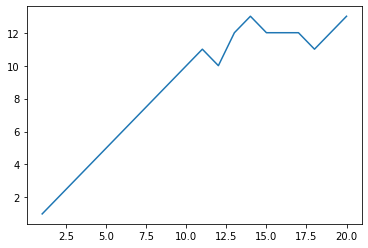

In [51]:
plt.plot(range(1, dmax+1), ranks)

### Extreme machines

In [52]:
def make_fourier_network(widths, input_dim):
    layers = []
    d_prev = input_dim
    for d in widths:
        W = np.random.normal(size=(d_prev, d))
        b = np.random.uniform(low=0, high=2*math.pi, size=d)
        layers.append({'W': W, 'b': b})
        d_prev = d
    def fourier_network(X):
        P = X
        for lay in layers:
            P = np.cos(np.matmul(P, lay['W']) + lay['b'])
        return P
    return fourier_network

In [53]:
layers = 2
dmax = 20
reg = 0.1
results = []
ranks = []
for d in range(1, dmax+1):
    rfm = make_fourier_network([d]*layers, 1)
    results.append(rf_fit(X, y, rfm, reg))
    ranks.append(np.linalg.matrix_rank(rfm(X)))

In [54]:
xx = np.linspace(domain[0], domain[1], num=1000)

def update(d):
    plt.scatter(X.squeeze(), y)
    plt.plot(xx, results[d-1][2](xx), 'orange')
    axes = plt.gca()
    axes.set_xlim(domain)
    axes.set_ylim(min(y) - 0.1, max(y) + 0.1)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=dmax, step=1, value=1))

interactive(children=(IntSlider(value=1, description='d', max=20, min=1), Output()), _dom_classes=('widget-int…

Rank of design matrix as a function of width

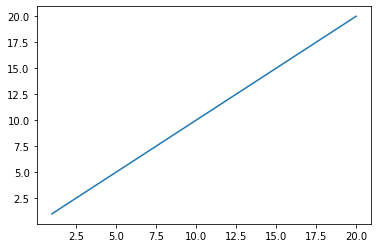

In [55]:
plt.plot(range(1, dmax+1), ranks)